In [28]:
import pandas as pd
import numpy as np
import re

In [29]:
#load the csv files as dataframes 
training = pd.read_csv("C:/cindy/ICL/machine learning/training.txt", encoding='latin-1')  #could use encoding = ISO-8859-1
validation = pd.read_csv("C:/cindy/ICL/machine learning/validation.txt", encoding='latin-1')
test1 = pd.read_csv("C:/cindy/ICL/machine learning/test1.txt",encoding='latin-1')
test2 = pd.read_csv("C:/cindy/ICL/machine learning/test2.txt",encoding='latin-1')

In [30]:
#load the txt files as dataframes 
clt1 = pd.read_csv("C:/cindy/ICL/machine learning/censored_list_test1.txt")
clt2 = pd.read_csv("C:/cindy/ICL/machine learning/censored_list_test2.txt")

In [31]:
training

,label,sms
0,ham,Just sent again. Do you scream and moan in bed...
1,ham,When i have stuff to sell i.ll tell you
2,ham,Ugh fuck it I'm resubbing to eve
3,ham,Change windows logoff sound..
4,ham,"Ití_ís í«£6 to get in, is that ok?"
...,...,...
2096,ham,"Received, understood n acted upon!"
2097,ham,Evening * v good if somewhat event laden. Will...
2098,ham,Just finished eating. Got u a plate. NOT lefto...
2099,ham,Even if he my friend he is a priest call him now


In [32]:
# Function to remove punctuation and numbers, and convert to lowercase
def clean_text(text):
    # Replace any character that is not a letter or whitespace and convert to lowercase
    cleaned_text = re.sub(r'[^A-Za-z\s]', '', text).lower()
    return cleaned_text

# Apply the function to the 'sms' column of each DataFrame
training['sms'] = training['sms'].apply(clean_text)
validation['sms'] = validation['sms'].apply(clean_text)
test1['sms'] = test1['sms'].apply(clean_text)
test2['sms'] = test2['sms'].apply(clean_text)

In [33]:
training

,label,sms
0,ham,just sent again do you scream and moan in bed ...
1,ham,when i have stuff to sell ill tell you
2,ham,ugh fuck it im resubbing to eve
3,ham,change windows logoff sound
4,ham,its to get in is that ok
...,...,...
2096,ham,received understood n acted upon
2097,ham,evening v good if somewhat event laden will f...
2098,ham,just finished eating got u a plate not leftove...
2099,ham,even if he my friend he is a priest call him now


In [34]:
validation

,label,sms
0,ham,i need details about that online job
1,ham,oh ok wait me there my lect havent finish
2,ham,you were supposed to wake me up gt
3,spam,for ur chance to win a cash every wk txt acti...
4,ham,how abt making some of the pics bigger
...,...,...
894,ham,tmr maybe can meet you at yck
895,ham,the word checkmate in chess comes from the per...
896,ham,can call in ltgt if thats ok
897,ham,ive told you will stop just dont let her get...


In [35]:
#define a class 
class NaiveBayesForSpam: 
    #define a method to train the classifier 
    def train(self, hamMessages, spamMessages):
        #create a set of unique words from ham and spam messages
        #make all the words a long string connected with -, split this string into words, and remove duplicates
        self.words = set('-'.join(hamMessages+spamMessages).split())
        #assign [0., 0.] to prior probabilities of ham and spam
        self.priors = np.zeros(2)
        #set the first value as the prior probabilities of ham 
        # P(ham) = num of ham messages / num of all messages
        self.priors[0] = float(len(hamMessages)/(len(spamMessages)+len(hamMessages)))
        #set the second value as the prior probabilities of spam 
        # P(spam) = num of spam messages / num of all messages
        self.priors[1] = 1.0 - self.priors[0]
        #create a list to store likelihoods
        self.likelihoods = []
        
        #iterate the every word in words
        for i, w in enumerate(self.words):
            #likelihood of the word appearing in ham messages = P(word|ham)
            #add 1 for Laplace smoothing to avoid zero probabilities
            prob1 = (1.0 + len([m for m in hamMessages if w in m])) / len(hamMessages)
            #likelihood of the word appearing in spam messages = P(word|spam)
            #add 1 for Laplace smoothing to avoid zero probabilities
            prob2 = (1.0 + len([m for m in spamMessages if w in m])) / len(spamMessages)
            #limit the max likelihood to be 0.95
            #each element in likelihoods is [P(word|ham), P(word|spam)]
            self.likelihoods.append([min(prob1, 0.95), min(prob2, 0.95)])
            #convert list likelihoods to array, transpose so that each row corresponds to a class
        self.likelihoods = np.array(self.likelihoods).T
    
    #alternative training method                 
    def train2(self, hamMessages, spamMessages):
        #same as train
        self.words = set('-'.join(hamMessages+spamMessages).split())
        self.priors = np.zeros(2)
        self.priors[0] = float(len(hamMessages)/(len(spamMessages)+len(hamMessages)))
        self.priors[1] = 1.0 - self.priors[0]
        self.likelihoods = []
        #create a list to store spam words
        spamkeywords = []
        
        #interate every word in words to calculate the likelihoods of the word in ham and spam                       
        for i, w in enumerate(self.words):
            prob1 = (1.0 + len([m for m in hamMessages if w in m])) / len(hamMessages) #P(word|ham)
            prob2 = (1.0 + len([m for m in spamMessages if w in m])) / len(spamMessages) #P(word|spam)
            #add a condition
            #if the word is much more likely to appear in spam
            if prob1*20 <prob2:
                self.likelihoods.append([min(prob1, 0.95), min(prob2, 0.95)])
                spamkeywords.append(w) #append that word to spamkeywords
        #update words to include only spamkeywords
        self.words = spamkeywords
        #likellihoods now include only filtered words (more likely in spam)
        self.likelihoods = np.array(self.likelihoods).T
    
    #define a method to make predictions
    def predict(self, message):
        #set the initial posterior probailities  as prior probabilities 
        posteriors = np.copy(self.priors)
        #iterate every word in words
        for i, w in enumerate(self.words):
            #if w is found in the message(case-insensitive)
            if w in message.lower(): 
                #updated posterior = posterior*likelihood
                posteriors*= self.likelihoods[:, i]
            else:
                #if w is not found in message, updated posterior = posterior*(1-likelihood)
                posteriors*= np.ones(2) - self.likelihoods[:, i]
            posteriors = posteriors/np.linalg.norm(posteriors, ord = 1) #normalise 
        if posteriors[0] > 0.5:
            return ['ham', posteriors[0]] #likely to be ham
        return ['spam', posteriors[1]] #likely to be spam
    
    #define a method to measure the accuracies of the classifier 
    def score(self, messages, labels):
        #initialize a confusion matrix
        confusion = np.zeros(4).reshape(2,2)
        #iterate every word in messages and give scores to confusion matrix
        for m, l in zip(messages, labels):
            #prediction is ham, actual label is ham
            if self.predict(m)[0] == 'ham' and l == 'ham':
                confusion[0,0]+=1
            #prediction is ham, actual label is spam
            elif self.predict(m)[0] == 'ham' and l == 'spam':
                confusion[0,1]+=1
            #prediction is spam, actual label is ham
            elif self.predict(m)[0] == 'spam' and l == 'ham':
                confusion[1,0]+=1
            #prediction is spam, actual label is spam
            elif self.predict(m)[0] == 'spam' and l == 'spam':
                confusion[1,1]+=1
        #return accuracy score = num of words correctly classified / num of all words , and the confusion matrix
        return (confusion[0,0] + confusion[1,1]) / float(confusion.sum()), confusion

In [36]:
#filter ham and spam message
hamMessages = training.loc[training['label'] == "ham"]["sms"].tolist()
spamMessages = training.loc[training['label'] == "spam"]["sms"].tolist()

In [37]:
#use method train to train classifier
classifier = NaiveBayesForSpam()
classifier.train(hamMessages, spamMessages)

In [38]:
#use method train2 to train the classifier2
classifier2 = NaiveBayesForSpam()
classifier2.train2(hamMessages, spamMessages)

In [39]:
#inputs for validation
messages = validation['sms'].tolist()
labels = validation['label'].tolist()

In [40]:
#validatation accuracy of classifier (train)
#the predict method is incorporated in score method
accuracy, c_matrix = classifier.score(messages, labels)

#print the results
print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(c_matrix)

Accuracy:  0.9655172413793104
Confusion Matrix: 
[[778.  21.]
 [ 10.  90.]]


In [41]:
#validatation accuracy of classifier2 (train2)
accuracy2, c_matrix2 = classifier2.score(messages, labels)

#print the results
print("Accuracy: ", accuracy2)
print("Confusion Matrix: ")
print(c_matrix2)

Accuracy:  0.9632925472747497
Confusion Matrix: 
[[784.  29.]
 [  4.  82.]]


In [15]:
#training accuracy of classifier (train)
t_accuracy, t_c_matrix = classifier.score(training['sms'].tolist(), training['label'].tolist())

#print the results
print("Accuracy: ", t_accuracy)
print("Confision Matrix: ")
print(t_c_matrix)

Accuracy:  0.96573060447406
Confision Matrix: 
[[1795.   41.]
 [  31.  234.]]


In [16]:
#training accuracy of classifier2 (train2)
t_accuracy2, t_c_matrix2 = classifier2.score(training['sms'].tolist(), training['label'].tolist())

#print the results
print("Accuracy: ", t_accuracy2)
print("Confision Matrix: ")
print(t_c_matrix2)

Accuracy:  0.9690623512613041
Confision Matrix: 
[[1819.   58.]
 [   7.  217.]]


train2 is faster than train due to its approach to handle the inputs. Specifically, the condition 'if prob1*20 < prob2' in train2 keeps only the words whose likelihood to be spam is significantly higher than likelihood to be ham (20 times higher). The condition results in fewer words in 'spamkeywords' and hence 'self.words', leading to shorter operation time to iterate through the input data and generate the accuracy outputs. 

train2 has higher accuracy regardless of using training or validation data, as it focuses on words more likely to be in spam messages given the additional condition and 'spamkeyword'. Therefore, classifier2, trained by train2, is less likely to be affected by noise or features that don't strongly differentiate betweem ham and spam. train2 might also reduce the risk of overfitting by excluding those less indicative words in the messages. 

There are 21 false positives when plugging validation data in train. 
There are 29 false positives when plugging validation data in train2. 

In [ ]:
'''
class NaiveBayesForSpam: 
    # ... (methods)

    def predict(self, message):
        # ... (previous code)
        # Adjust the threshold here
        ham_threshold = 0.3  # lowering the threshold to 0.3
        if posteriors[0] > ham_threshold:
            return ['ham', posteriors[0]] # More likely to be ham
        return ['spam', posteriors[1]] # More likely to be spam
'''

We can add a low ham threshold in the predict method. In the above example code, we lower the threshold from 0.5 to 0.3. That is, when the likelihood of the word being ham is higher than the threshold, the word will be classified as ham. The approach leads to more lenient classification of ham messages, increasing the number of messages being classified as ham and potentially reducing ones being misclassified as spam. The approach reduces false positives at the expense of false negatives, since it makes it harder to classify words as spam and some spam words could fall into ham. 

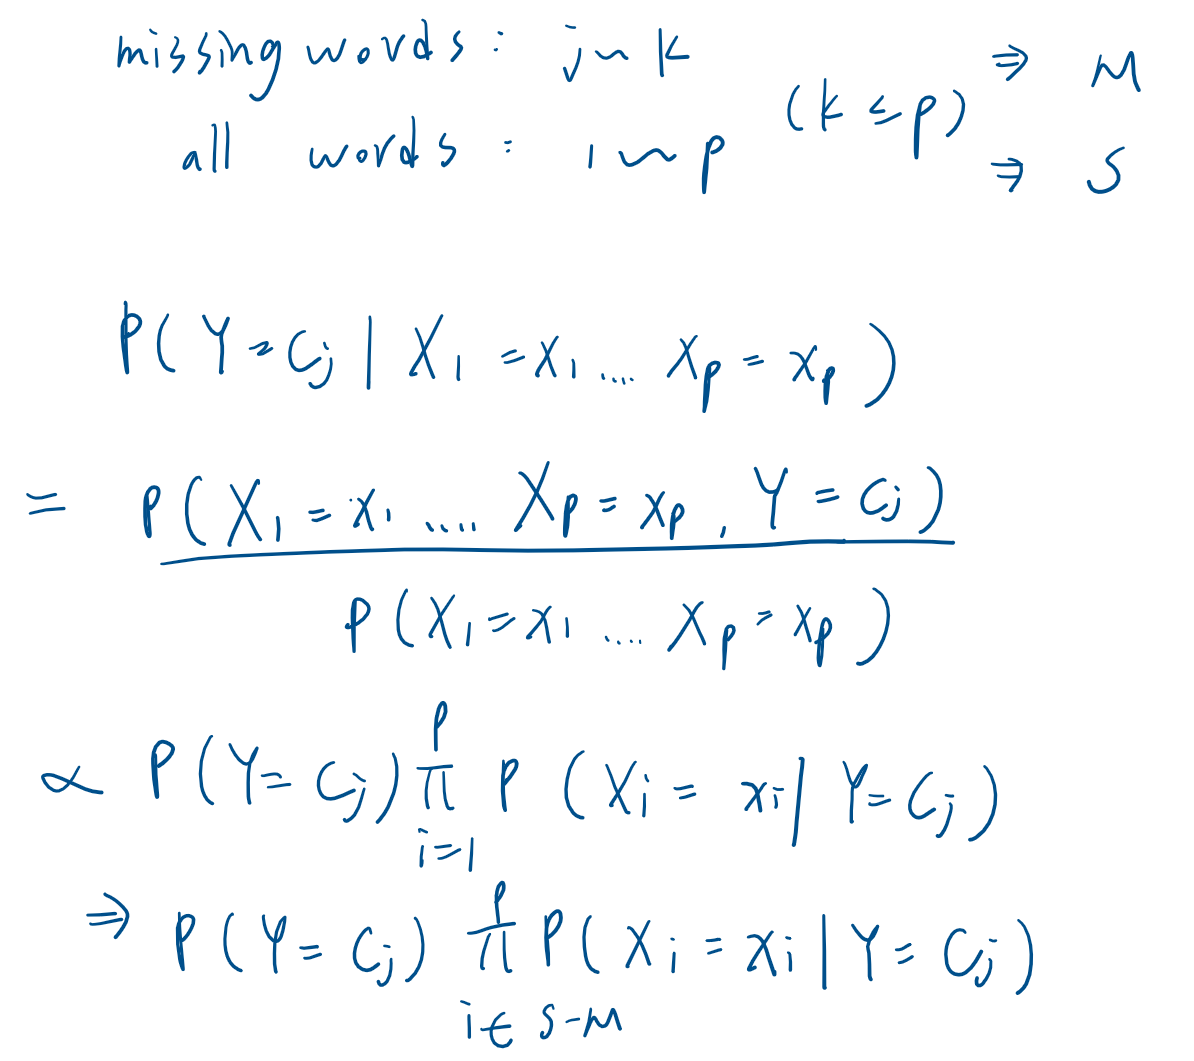

ignore the missing variables in computing the probability 

In [17]:
#define a class 
class NaiveBayesForSpam: 
    #define a method to train the classifier 
    def train(self, hamMessages, spamMessages):
        #create a set of unique words from ham and spam messages
        #make all the words a long string connected with -, split this string into words, and remove duplicates
        self.words = set('-'.join(hamMessages+spamMessages).split())
        #assign [0., 0.] to prior probabilities of ham and spam
        self.priors = np.zeros(2)
        #set the first value as the prior probabilities of ham 
        # P(ham) = num of ham messages / num of all messages
        self.priors[0] = float(len(hamMessages)/(len(spamMessages)+len(hamMessages)))
        #set the second value as the prior probabilities of spam 
        # P(spam) = num of spam messages / num of all messages
        self.priors[1] = 1.0 - self.priors[0]
        #create a list to store likelihoods
        self.likelihoods = []
        
        #iterate the every word in words
        for i, w in enumerate(self.words):
            #likelihood of the word appearing in ham messages = P(word|ham)
            #add 1 for Laplace smoothing to avoid zero probabilities
            prob1 = (1.0 + len([m for m in hamMessages if w in m])) / len(hamMessages)
            #likelihood of the word appearing in spam messages = P(word|spam)
            #add 1 for Laplace smoothing to avoid zero probabilities
            prob2 = (1.0 + len([m for m in spamMessages if w in m])) / len(spamMessages)
            #limit the max likelihood to be 0.95
            #each element in likelihoods is [P(word|ham), P(word|spam)]
            self.likelihoods.append([min(prob1, 0.95), min(prob2, 0.95)])
            #convert list likelihoods to array, transpose so that each row corresponds to a class
        self.likelihoods = np.array(self.likelihoods).T
    
    #alternative training method                 
    def train2(self, hamMessages, spamMessages):
        #same as train
        self.words = set('-'.join(hamMessages+spamMessages).split())
        self.priors = np.zeros(2)
        self.priors[0] = float(len(hamMessages)/(len(spamMessages)+len(hamMessages)))
        self.priors[1] = 1.0 - self.priors[0]
        self.likelihoods = []
        #create a list to store spam words
        spamkeywords = []
        
        #interate every word in words to calculate the likelihoods of the word in ham and spam                       
        for i, w in enumerate(self.words):
            prob1 = (1.0 + len([m for m in hamMessages if w in m])) / len(hamMessages) #P(word|ham)
            prob2 = (1.0 + len([m for m in spamMessages if w in m])) / len(spamMessages) #P(word|spam)
            #add a condition
            #if the word is much more likely to appear in spam
            if prob1*20 <prob2:
                self.likelihoods.append([min(prob1, 0.95), min(prob2, 0.95)])
                spamkeywords.append(w) #append that word to spamkeywords
        #update words to include only spamkeywords
        self.words = spamkeywords
        #likellihoods now include only filtered words (more likely in spam)
        self.likelihoods = np.array(self.likelihoods).T
    
    #revise predict
    def predict2(self, message):
        # Initialize the posterior probabilities as the prior probabilities
        posteriors = np.copy(self.priors)

        # Process the message: Convert to lowercase and split into words
        processed_message = message.lower().split()

        # Iterate over each word in the processed message
        for word in processed_message:
            if word in self.words:
                # Find the index of the word in self.words
                word_index = list(self.words).index(word)
                # Update posterior probabilities for words observed in training
                posteriors *= self.likelihoods[:, word_index]
            # If the word wasn't seen during training, we simply skip it

        # Normalize the posterior probabilities
        posteriors = posteriors / np.linalg.norm(posteriors, ord=1)

        # Make the prediction based on the posterior probabilities
        if posteriors[0] > 0.5:
            return ['ham', posteriors[0]]
        return ['spam', posteriors[1]]
    
    #define a method to measure the accuracies of the classifier 
    def score2(self, messages, labels):
        #initialize a confusion matrix
        confusion = np.zeros(4).reshape(2,2)
        #iterate every word in messages and give scores to confusion matrix
        for m, l in zip(messages, labels):
            #prediction is ham, actual label is ham
            if self.predict2(m)[0] == 'ham' and l == 'ham':
                confusion[0,0]+=1
            #prediction is ham, actual label is spam
            elif self.predict2(m)[0] == 'ham' and l == 'spam':
                confusion[0,1]+=1
            #prediction is spam, actual label is ham
            elif self.predict2(m)[0] == 'spam' and l == 'ham':
                confusion[1,0]+=1
            #prediction is spam, actual label is spam
            elif self.predict2(m)[0] == 'spam' and l == 'spam':
                confusion[1,1]+=1
        #return accuracy score = num of words correctly classified / num of all words , and the confusion matrix
        return (confusion[0,0] + confusion[1,1]) / float(confusion.sum()), confusion

In [18]:
#use method train to train classifier
classifier = NaiveBayesForSpam()
classifier.train(hamMessages, spamMessages)

In [19]:
#use method train2 to train classifier
classifier2 = NaiveBayesForSpam()
classifier2.train2(hamMessages, spamMessages)

In [20]:
#seperate sms and label in test1
t_messages = test1['sms'].tolist()
t_labels = test1['label'].tolist()

In [21]:
#test1, train, predict2
accuracy, c_matrix = classifier.score2(t_messages, t_labels)

#print the results
print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(c_matrix)

Accuracy:  0.677570093457944
Confusion Matrix: 
[[701.   0.]
 [414. 169.]]


In [22]:
#test1, train2, predict2
accuracy, c_matrix = classifier2.score2(t_messages, t_labels)

#print the results
print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(c_matrix)

Accuracy:  0.9493769470404985
Confusion Matrix: 
[[1070.   20.]
 [  45.  149.]]


In [23]:
#test2
t2_messages = test2['sms'].tolist()
t2_labels = test2['label'].tolist()

In [24]:
#test2, train, predict2
accuracy, c_matrix = classifier.score2(t2_messages, t2_labels)

#print the results
print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(c_matrix)

Accuracy:  0.7091757387247278
Confusion Matrix: 
[[724.   4.]
 [370. 188.]]


In [25]:
#test2, train2, predict2
accuracy, c_matrix = classifier2.score2(t2_messages, t2_labels)

#print the results
print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(c_matrix)

Accuracy:  0.9494556765163297
Confusion Matrix: 
[[1053.   24.]
 [  41.  168.]]


With the revised predict method, we ignore the probability of a word if it appears in test but not in training. We remove the calculation of 'updated posterior = posterior*(1-likelihood)' shown in the first part. 

- An accuracy of 67.76% is achieved when we input test1 (remove 10% of keywords) and use train method.
- An accuracy of 94.94% is achieved when we input test1 (remove 10% of keywords) and use train2 method.
- An accuracy of 70.92% is achieved when we input test2 (remove 30% of keywords) and use train method.
- An accuracy of 94.95% is achieved when we input test2 (remove 30% of keywords) and use train2 method.

With the same input (test1 or test2), the accuracies improved when we switch from train to train2 method, which is in accordance with the previous finding. With the same training method (train or train2), the accuracies improved when we switch the input from test1 to test2. That is, the model performs better when making predictions for inputs with a lot of unseen words.  

It's interesting to find out the model performs better on test2 with 30% missing data compared to test1 with only 10% missing data. In a typical scenario, one would expect a model to perform better with less missing data, as more information is usually beneficial for making accurate predictions. However, several factors could lead to the observed behavior:

- Data Distribution and Representativeness: If test2, despite having more missing data, is more representative of the data distribution the model was trained on, it could lead to better performance. In contrast, test1 might have missing data in more informative areas, reducing its representativeness. Another way to put this is that the remaining data in test2 is higher-quality than one in test1, and such result derives from the random variability of data. 
- Overfitting to Non-Missing Data: If the model is overfitting to the non-missing data in test1, it might perform worse on this dataset. In contrast, the increased amount of missing data in test2 could reduce the model's tendency to overfit, leading to better generalization.
- Noise Reduction: In some cases, removing data can act as a noise reduction technique. If the 30% of data removed from test2 includes more noise or irrelevant information compared to test1, this could lead to improved performance.

In [26]:
#trainning data, train, predict2
accuracy, c_matrix = classifier.score2(training['sms'].tolist(), training['label'].tolist())

#print the results
print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(c_matrix)

Accuracy:  0.6392194193241314
Confusion Matrix: 
[[1.069e+03 1.000e+00]
 [7.570e+02 2.740e+02]]


In [27]:
#trainning data, train2, predict2
accuracy, c_matrix = classifier2.score2(training['sms'].tolist(), training['label'].tolist())

#print the results
print("Accuracy: ", accuracy)
print("Confusion Matrix: ")
print(c_matrix)

Accuracy:  0.9595430747263208
Confusion Matrix: 
[[1771.   30.]
 [  55.  245.]]
